# Tensorflow Tokenizer 복습

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [1]:
sentences = ['nice great best amazing', 'stop lies', 'pitiful nerd', 'excellent word', 'supreme qulity', 'bad', 'highly respectable']
y_train = [1, 0, 0, 1, 1, 0, 1]

In [3]:
t = Tokenizer()
t.fit_on_texts(sentences) # 텍스트 -> 리스트
vocab_size = len(t.word_index) +1
print(vocab_size)

16


In [4]:
print(t.word_index)

{'nice': 1, 'great': 2, 'best': 3, 'amazing': 4, 'stop': 5, 'lies': 6, 'pitiful': 7, 'nerd': 8, 'excellent': 9, 'word': 10, 'supreme': 11, 'qulity': 12, 'bad': 13, 'highly': 14, 'respectable': 15}


In [5]:
x_encoded = t.texts_to_sequences(sentences) # 텍스트 -> 시퀀스
print(x_encoded)

[[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [7]:
# x_encoded의 최대값 구하기
max_len = max(len(sample) for sample in x_encoded)
print(max_len)

4


In [8]:
type(y_train)

list

In [10]:
x_train = pad_sequences(x_encoded, maxlen=max_len, padding='post')
y_train = np.array(y_train)
print(type(y_train))
print(x_train)

<class 'numpy.ndarray'>
[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


In [11]:
type(x_train)

numpy.ndarray

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

youngwoo = Sequential()
youngwoo.add(Embedding(vocab_size, 2, input_length=max_len))
youngwoo.add(Flatten())
youngwoo.add(Dense(1, activation='sigmoid'))
youngwoo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 2)              32        
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [13]:
youngwoo.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['acc']
)
youngwoo.fit(x_train, y_train, epochs=100, verbose=1)

Epoch 1/100
1/1 [==============================] - 1s 825ms/step - loss: 0.6883 - acc: 0.7143
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6876 - acc: 0.8571
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 0.6869 - acc: 0.8571
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6862 - acc: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6855 - acc: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6848 - acc: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6841 - acc: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6834 - acc: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6827 - acc: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6820 - acc: 1.0000
Epoch 11/100
1/1 [==============================] - 0s 10ms/step - loss: 0.

# 네이버 영화 리뷰 감성 분석

In [14]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f58089faf10>)

In [16]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [17]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [18]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 522 kB/s 
     |████████████████████████████████| 453 kB 49.1 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-24 01:29:30--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.

In [19]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [21]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # mecab 형태소 분석 tokenizer
        curr_data = [word for word in curr_data if not word in stopwords] # 불용어 제거
        result.append(curr_data)
    return result

In [22]:
def load_data(train_data, test_data, num_words=10000):

    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # Nan 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중...
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [23]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [24]:
print(x_train[10])

[2, 4, 39, 229, 6, 535]


In [25]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [26]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.

def get_encoded_sentence(sentence, word_to_index): ##### 텍스트 -> 숫자
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. ##### 숫자 -> 텍스트
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [27]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

In [28]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 : 15.96940191154864
문장길이 최대 : 116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [29]:
# 패딩 추가
x_train = pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [30]:
print(x_train)

[[   0    0    0 ...   20   33  748]
 [   0    0    0 ...   15   44  391]
 [   0    0    0 ...   24  205    2]
 ...
 [   0    0    0 ... 2710    6   18]
 [   0    0    0 ...   60  395 8572]
 [   0    0    0 ...   88 2740    5]]


In [31]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


In [32]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [33]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 25
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/25
188/188 [==============================] - 39s 186ms/step - loss: 0.4888 - accuracy: 0.7894 - val_loss: 0.3703 - val_accuracy: 0.8441
Epoch 2/25
188/188 [==============================] - 25s 132ms/step - loss: 0.3322 - accuracy: 0.8625 - val_loss: 0.3478 - val_accuracy: 0.8497
Epoch 3/25
188/188 [==============================] - 25s 132ms/step - loss: 0.2955 - accuracy: 0.8794 - val_loss: 0.3451 - val_accuracy: 0.8526
Epoch 4/25
188/188 [==============================] - 25s 132ms/step - loss: 0.2693 - accuracy: 0.8913 - val_loss: 0.3509 - val_accuracy: 0.8510
Epoch 5/25
188/188 [==============================] - 25s 133ms/step - loss: 0.2484 - accuracy: 0.9000 - val_loss: 0.3595 - val_accuracy: 0.8501
Epoch 6/25
188/188 [==============================] - 25s 136ms/step - loss: 0.2293 - accuracy: 0.9092 - val_loss: 0.3772 - val_accuracy: 0.8476
Epoch 7/25
188/188 [==============================] - 25s 131ms/step - loss: 0.2115 - accuracy: 0.9167 - val_loss: 0.3921 - val_ac

In [35]:
results = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 10s - loss: 0.8680 - accuracy: 0.8244 - 10s/epoch - 7ms/step


In [36]:
print(results)

[0.8679764866828918, 0.8243993520736694]


In [37]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

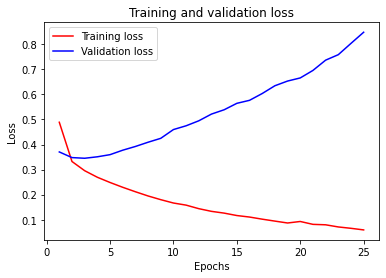

In [39]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

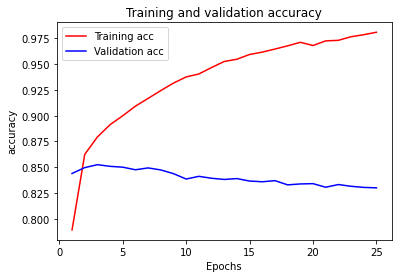

In [40]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 학습된 embedding layer 분석

In [50]:
# gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = './word2vec.txt'
f = open(word2vec_file_path,'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 

vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [52]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['짜증']
vector

array([ 0.08781449, -0.08766752,  0.04978276,  0.10810341, -0.07918941,
        0.13566475,  0.17498271,  0.16459092, -0.20398091,  0.13464099,
       -0.1420083 , -0.0545604 , -0.12088495, -0.1534736 , -0.21808901,
        0.15511024, -0.08037407,  0.16861816,  0.20484103, -0.03932282,
        0.08217884,  0.17657019, -0.081654  ,  0.08590914, -0.30644447,
       -0.16491392, -0.1724101 ,  0.2213363 ,  0.06971332,  0.10405178,
       -0.25712562,  0.23297478, -0.09159052, -0.1090795 ,  0.08078763,
        0.11473452,  0.18132123,  0.11639699,  0.21532299,  0.14298406,
        0.147034  , -0.04564452, -0.01287362, -0.15960832, -0.1379897 ,
       -0.02318664,  0.06640818, -0.01679059,  0.18034579,  0.02809306,
       -0.07812469, -0.08740526, -0.1078017 , -0.03884134,  0.06082889,
        0.00994078, -0.0854832 ,  0.0778253 ,  0.16631496,  0.12635422,
        0.19045946, -0.04140799,  0.11419298,  0.04889754, -0.0946796 ,
        0.13242033, -0.12508065, -0.07652012, -0.18156047, -0.07

In [53]:
word_vectors.similar_by_word("재미")

[('풀', 0.5569577813148499),
 ('큐브', 0.5376416444778442),
 ('이대로', 0.5329992771148682),
 ('거의', 0.5313494801521301),
 ('로렌스', 0.5263041257858276),
 ('가치관', 0.525813639163971),
 ('의리', 0.5129775404930115),
 ('김수로', 0.506064772605896),
 ('화끈', 0.4897662401199341),
 ('동떨어진', 0.47962695360183716)]

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 한국어 word2vec 임베딩 활용해 성능 개선

In [56]:
import gensim

word2vec_path = '/content/drive/MyDrive/영우_6기_자연어/수업안/dataset/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['감동']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([-1.4411083 , -0.78142536,  2.453768  , -0.86445606,  0.24195324,
        0.36006922, -1.0639709 ,  0.85037315, -1.0184479 ,  0.21196692,
       -0.6679936 ,  0.6389819 , -0.26964295,  0.66028535,  0.39613017,
        0.6428288 ,  0.6648245 ,  0.08363932, -0.2540794 ,  0.55310047,
        0.63392764,  0.19311981, -0.4648248 ,  0.1490374 ,  2.0762694 ,
        0.7872764 , -0.21711552, -0.59049505, -1.3264338 , -0.06233318,
        1.2550159 , -0.05334642, -0.5453753 , -0.8736315 ,  0.5253877 ,
        0.03122815,  0.8280226 ,  0.23597455,  0.06136359,  1.5114233 ,
       -0.340495  ,  0.912277  ,  0.5899006 , -1.3025732 , -0.87596595,
        0.21738248,  1.0366931 , -0.55709684, -0.9039502 ,  0.28133616,
       -1.7572548 , -0.29769212, -0.14536098,  0.5850025 , -0.6111547 ,
       -0.29829553,  1.4106004 , -0.38685524,  0.4801454 ,  0.40166005,
        0.28174093,  1.6133646 , -0.8590998 ,  0.49886975,  0.38605362,
       -0.1607663 , -0.87983316,  0.21996935,  0.68561727, -0.84

In [57]:
word2vec.similar_by_word("로맨틱")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('코미디', 0.7576364278793335),
 ('로맨스', 0.7021660804748535),
 ('스릴러', 0.6693054437637329),
 ('개그', 0.6552960872650146),
 ('주제곡', 0.6495761871337891),
 ('뮤지컬', 0.6382305026054382),
 ('시트콤', 0.6167846322059631),
 ('서부극', 0.6151247620582581),
 ('연극과', 0.6083630323410034),
 ('서정적', 0.5965933799743652)]

In [59]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 200 # 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [60]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                    embeddings_initializer=Constant(embedding_matrix), # 카피한 임베딩을 여기서 활용
                    input_length = maxlen,
                    trainable = True # fine-tuning
                    ))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 35, 16)            22416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 8)                

In [61]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 25
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/25
188/188 [==============================] - 58s 302ms/step - loss: 0.5966 - accuracy: 0.6634 - val_loss: 0.4825 - val_accuracy: 0.7691
Epoch 2/25
188/188 [==============================] - 58s 306ms/step - loss: 0.4262 - accuracy: 0.8080 - val_loss: 0.4075 - val_accuracy: 0.8162
Epoch 3/25
188/188 [==============================] - 36s 193ms/step - loss: 0.3543 - accuracy: 0.8476 - val_loss: 0.3703 - val_accuracy: 0.8380
Epoch 4/25
188/188 [==============================] - 37s 195ms/step - loss: 0.3090 - accuracy: 0.8710 - val_loss: 0.3633 - val_accuracy: 0.8427
Epoch 5/25
188/188 [==============================] - 40s 212ms/step - loss: 0.2767 - accuracy: 0.8875 - val_loss: 0.3646 - val_accuracy: 0.8431
Epoch 6/25
188/188 [==============================] - 36s 193ms/step - loss: 0.2496 - accuracy: 0.9021 - val_loss: 0.3761 - val_accuracy: 0.8431
Epoch 7/25
188/188 [==============================] - 37s 196ms/step - loss: 0.2220 - accuracy: 0.9152 - val_loss: 0.3931 - val_ac

In [62]:
result = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 5s - loss: 0.9273 - accuracy: 0.8188 - 5s/epoch - 4ms/step
